## Recommender System item based Collaborative Filtering with Nearest Neighbor 


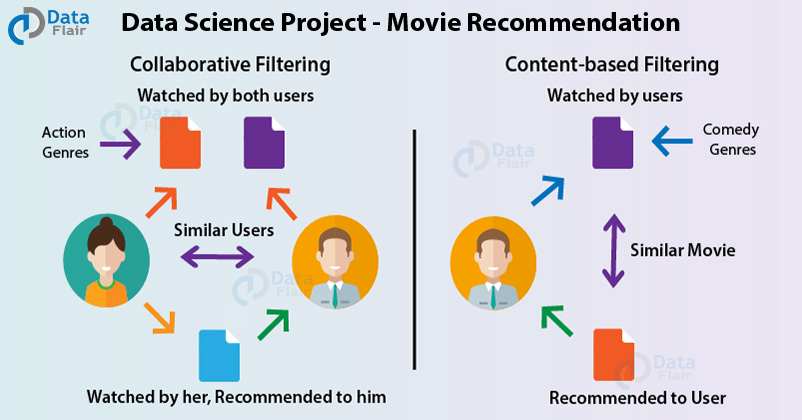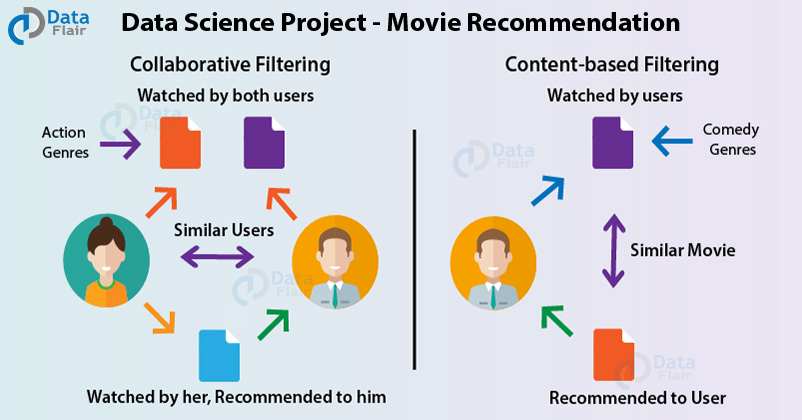

### import required libraries

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
movie  = pd.read_csv('C:/Users/shekh/Desktop/Recommendation System/Recommendation system collaborative item based/movies.csv')
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies = pd.read_csv('C:/Users/shekh/Desktop/Recommendation System/Recommendation system collaborative item based/movies.csv',usecols=['movieId','title'],dtype={'movieId': 'int32', 'title': 'str'})
rating=pd.read_csv('C:/Users/shekh/Desktop/Recommendation System/Recommendation system collaborative item based/ratings.csv',usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})


In [4]:
movies.tail()

,movieId,title
9737,193581,Black Butler: Book of the Atlantic (2017)
9738,193583,No Game No Life: Zero (2017)
9739,193585,Flint (2017)
9740,193587,Bungo Stray Dogs: Dead Apple (2018)
9741,193609,Andrew Dice Clay: Dice Rules (1991)


In [5]:
movies['title'] = movies['title'].str.replace(r"\(.*\)","")
movies['title'] = movies['title'].str[:-1].replace(' ', '')

In [6]:
movies.tail()

,movieId,title
9737,193581,Black Butler: Book of the Atlantic
9738,193583,No Game No Life: Zero
9739,193585,Flint
9740,193587,Bungo Stray Dogs: Dead Apple
9741,193609,Andrew Dice Clay: Dice Rules


In [7]:
movies[movies['title'] == 'Zombieland']

,movieId,title
7154,71535,Zombieland


In [8]:
rating.tail()

,userId,movieId,rating
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0
100835,610,170875,3.0


In [9]:
dataset = pd.merge(rating,movies,on='movieId')
dataset.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story
1,5,1,4.0,Toy Story
2,7,1,4.5,Toy Story
3,15,1,2.5,Toy Story
4,17,1,4.5,Toy Story


In [10]:
combine_movie_rating = dataset.dropna(axis = 0, subset = ['title'])
movie_ratingCount = (combine_movie_rating.
     groupby(by = ['title'])['rating'].
     count().
     reset_index().
     rename(columns = {'rating': 'totalRatingCount'})
     [['title', 'totalRatingCount']]
    )
movie_ratingCount.head()

,title,totalRatingCount
0,,42
1,'71,1
2,'Hellboy': The Seeds of Creation,1
3,'Round Midnight,2
4,'Salem's Lot,1


In [11]:
rating_totalRatingCount = combine_movie_rating.merge(movie_ratingCount, left_on = 'title', right_on = 'title', how = 'left')
rating_totalRatingCount.tail()

,userId,movieId,rating,title,totalRatingCount
100831,610,160341,2.5,Bloodmoon,1
100832,610,160527,4.5,Sympathy for the Underdog,1
100833,610,160836,3.0,Hazard,1
100834,610,163937,3.5,Blair Witch,1
100835,610,163981,3.5,31,1


In [12]:
round(movie_ratingCount['totalRatingCount'].describe(),2)

count    9397.00
mean       10.73
std        22.90
min         1.00
25%         1.00
50%         3.00
75%         9.00
max       329.00
Name: totalRatingCount, dtype: float64

In [44]:
popularity_threshold = 20
rating_popular_movie= rating_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_movie.head()

,userId,movieId,rating,title,totalRatingCount
0,1,1,4.0,Toy Story,215
1,5,1,4.0,Toy Story,215
2,7,1,4.5,Toy Story,215
3,15,1,2.5,Toy Story,215
4,17,1,4.5,Toy Story,215


In [45]:
## First lets create a Pivot matrix

movie_features_df=rating_popular_movie.pivot_table(index='title',columns='userId',values='rating').fillna(0)
movie_features_df.tail()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
Zoolander,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0
Zootopia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
eXistenZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0
xXx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,2.0
¡Three Amigos!,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
from scipy.sparse import csr_matrix

movie_features_df_matrix = csr_matrix(movie_features_df.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric= 'cosine', algorithm = 'brute')
model_knn.fit(movie_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [47]:
movie_features_df.shape

(1304, 610)

In [48]:
movie_features_df.head(1)

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5


# Enter the movie name for which you want recommendation and make sure it is 
movie = input("Enter the movie name for recommendation: ")


In [49]:
movie_name = 'Kung Fu Panda'
print(movie_name)
distances, indices = model_knn.kneighbors(movie_features_df.loc[movie_name,:].values.reshape(1, -1), n_neighbors = 6)

Kung Fu Panda


In [50]:
movie_features_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5
10 Things I Hate About You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13 Going on 30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [51]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(movie_name))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, movie_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Kung Fu Panda:

1: Sherlock Holmes, with distance of 0.4091447591781616:
2: Avatar, with distance of 0.41309165954589844:
3: Despicable Me, with distance of 0.4181268811225891:
4: Iron Man, with distance of 0.43218034505844116:
5: Zombieland, with distance of 0.45817863941192627:
